# **11762 Content-Based Image Retrieval**
## Master's Degree in Intelligent Systems
### University of the Balearic Islands
---

##### Write in the following the names of the members of the group:
- **Member 1:** Aina Maria Tur Serrano
- **Member 2:** Frank William Hammond Espinosa

# **Instructions**

**Do not delete any of the provided cells or functions**. Write your code in the indicated sections. You may add new cells or functions as needed to complete your work.  

Along with this assignment, please submit a comprehensive **report** in PDF format explaining your implemented solutions. The report should include, for example:

- **Technical Explanation**: Clearly describe the algorithms and techniques used, including relevant code snippets.
- **Results**: Present your results in a clear and concise manner. Use visualizations such as graphs or tables to enhance understanding.
- **Analysis**: Interpret your results and discuss their significance. Consider, for instance, the following questions:
  - Are the results as expected? Why or why not?
  - What factors might have influenced the results?
- **Conclusions**: Summarize your findings and provide overall conclusions about your project.
- ---

In [2]:
# Execute this cell to make sure 
# that external modules are reloaded
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
# Fill the following variable with
# the path to the Holidays (or Mini) dataset
dataset_dir = 'holidays_mini'

In [4]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import skimage.feature as skfeat
import zipfile
from holidays_dataset_handler import HolidaysDatasetHandler
from typing import Callable
import json

import assignment1 as a1

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# **Introduction**
In this assignment, you will first learn the tools that will be used throughout the labs. Then, you will implement and evaluate various image description methods to develop a simple Content-Based Image Retrieval (CBIR) system.

### Tools
Several tools and libraries will be used throughout the semester, including:

*   [Python 3](https://docs.python.org/3/tutorial/)
*   [NumPy](https://docs.scipy.org/doc/numpy/user/quickstart.html)
*   [OpenCV](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

It is important to familiarize yourself with these tools. If you are not already familiar with them, please follow the links above and explore the tutorials. Quickstart guides are also available on the course website on [Aula Digital](https://ad.uib.es/).

### The INRIA Holidays Dataset
During this course, we will primarily use the INRIA Holidays dataset. This dataset consists of a collection of personal holiday photos from the authors, along with additional images purposefully taken to evaluate robustness to image transformations such as rotations, viewpoint changes, illumination variations, blurring, and more. The dataset includes a wide variety of scene types (natural landscapes, man-made structures, water, fire effects, etc.), with all images available in high resolution.

The dataset is organized into **500 groups**, each representing a distinct scene or object. For evaluation, the first image in each group serves as a **query image**, and the other images in the group are considered **relevant images** for that query. For example:

- *100900.jpg* is the query image.
- *100901.jpg* and *100902.jpg* are relevant images from the same group.

The dataset comprises a total of **1491 images**, including:

- **500 queries** (one for each group).
- **991 relevant images**.

### The INRIA Holidays Dataset (MINI)
To facilitate development, a reduced version of the INRIA Holidays dataset, called the *mini* dataset, is provided. **You should mainly use this version for this assignment.** It contains **50 images**, including:

- **19 queries**.
- **31 relevant images**.

> **Note**: Both datasets can be downloaded from [Aula Digital](https://ad.uib.es/). After downloading, unzip the files into a writable directory on your machine. Ensure that the corresponding variable at the beginning of this notebook is updated with the correct path to the dataset.

The datasets follow this structure:
```
holidays/
  ├── holidays_images.dat
  ├── images/
  │     ├── 100000.jpg
  │     ├── 100001.jpg
  │     └── ...
  └── features/
        ├── 100000.siftgeo
        ├── 100001.siftgeo
        └── ...
  ...
```
where:

- **`holidays_images.dat`**: This file lists the filenames of all images in the dataset.
- **`images/`**: Contains the high-resolution image files.
- **`features/`**: Includes the `.siftgeo` files, which store a set of extracted features (keypoints and descriptors) using SIFT for each image. Ensure these files are present if feature-based operations are required.

The `holidays_images.dat` file can also serve as ground truth for performance evaluation of retrieval systems, as explained in a later section.

### Using the *HolidaysDatasetHandler* Class
The `HolidaysDatasetHandler` class is designed to help you manage and interact with the INRIA Holidays dataset efficiently. It provides functionality for loading images, extracting keypoints and descriptors, and calculating evaluation metrics like Average Precision (AP) and Mean Average Precision (mAP).

**Key Features**
- Load and retrieve query/database images.
- Access ground truth data for evaluation.
- Load precomputed keypoints and descriptors for feature-based tasks.
- Compute AP and mAP for query evaluation.

#### Example Usage
**Importing and Initializing**
```python
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=True)
```

**Loading and Displaying an Image**
```python
# Get an image from the dataset
image_name = "100900.jpg"
image = dataset.get_image(image_name)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional, to hide axes
plt.show()
```

**Accesing Query and Database Images**
```python
# List all query images
query_images = dataset.get_query_images()
print(f"Number of query images: {len(query_images)}")

# List all database images
database_images = dataset.get_database_images()
print(f"Number of database images: {len(database_images)}")
```

**Loading Keypoints and Descriptors**
```python
# Load keypoints and descriptors for a specific image
kps = dataset.get_kps("100900.jpg")
descs = dataset.get_descriptors("100900.jpg")

# Print the first keypoint and its descriptor
print(f"Keypoint: {kps[0].pt}, Descriptor shape: {descs.shape}")
```

**Computing Average Precision (AP)**
```python
# Compute AP for a single query with a ranked list of images
query_name = "100900.jpg"
ranked_list = ["100901.jpg", "100902.jpg"]
ap = dataset.compute_AP(query_name, ranked_list)
print(f"Average Precision (AP) for {query_name}: {ap}")
```

**Computing Mean Average Precision (mAP)**
```python
# Compute mAP for multiple queries
ranked_dict = {
    "100900.jpg": ["100901.jpg", "100902.jpg"],
    "101000.jpg": ["101001.jpg"]
}
map_score = dataset.compute_mAP(ranked_dict)
print(f"Mean Average Precision (mAP): {map_score}")
```

## **Global Descriptors**

Once our development environment is set up, we can begin working on the assignment. In this section, we will explore and evaluate various global descriptors to build a simple image retrieval system.

### General Framework

To streamline our workflow, we will begin by developing essential utility functions and classes. Start by implementing a [Python class]((https://docs.python.org/3/tutorial/classes.html)) named `CBIR` in `assignment1.py`, which will encapsulate the core functionalities of a CBIR system. The class should adhere to the provided method descriptions. Assume the existence of a function, `desc_func`, that computes a global descriptor for a given image. This design enables the use of the same class with different descriptor methods, as we will explore later in the assignment.

### Color Histograms
- Let's begin with histograms. In the `assignment1.py` file, implement the function `compute_1d_color_hist` to compute a descriptor based on a 1D color histogram. The final image descriptor will be the concatenation of the **normalized** color histograms from the three individual channels (B, G, and R).

- Next, implement the function called `compute_2d_color_hist` to compute a global descriptor for the image using 2D color histograms. The image descriptor will be the concatenation of the **normalized** histograms derived from the three possible combinations of color channels (B/G, B/R, and G/R).

> **Useful functions**: [cv2.calcHist](https://docs.opencv.org/4.2.0/d6/dc7/group__imgproc__hist.html), [np.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)

Check your implementations using the following cell:

In [4]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False) # We don't need features now

# Get an image from the dataset
image_name = "100900.jpg"
image = dataset.get_image(image_name)

# Bins: 32
h = a1.compute_1d_color_hist(image, 32);
assert h.shape == (96, )

# Bins: 16
h = a1.compute_1d_color_hist(image, 16);
assert h.shape == (48, )

# Bins: 8
h = a1.compute_1d_color_hist(image, 8);
assert h.shape == (24, )

# Bins: 32
h = a1.compute_2d_color_hist(image, 32);
assert h.shape == (3072, )

# Bins: 16
h = a1.compute_2d_color_hist(image, 16);
assert h.shape == (768, )

**Task 1:**

Using the `HolidaysDatasetHandler` and `CBIR` classes, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset. The image descriptors should be calculated using **1D histograms** with **8 bins**.

In [5]:
# Fill this variable with the resulting mAP
mAP_hist_1d = 0.0

dataset = a1.DatasetHandler(dataset_dir, load_features=False)
retriever = a1.GlobalCBIR(a1.compute_1d_color_hist, bins_per_hist=8)
retriever.build_image_db(dataset.load_database_images())
mAP_hist_1d = retriever.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_hist_1d)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.70903


**Task 2:**

Study the effect of changing the number of bins per histogram.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

Note that there are $2^8$ possible values for the intensity of a given pixel ($0, 1, \dots, 255$). Call a binning **homogenous** if each bin has the same number of assigned values (for instance, $0-31, 32-64, \dots, 224-255$). This implies that if $v$ is the number of different values per bin in a homogenous binning of pixel intensities, and $n$ is the number of bins, then $n\cdot v=2^8$. This means that $n=2^k$ for some $k\in\{0,\dots,8\}$.

Therefore, a good criterion to choose the optimal number of bins is to look only for homogenous binnings, and thus vary $k$ and find the highest mAP among all possibilities.

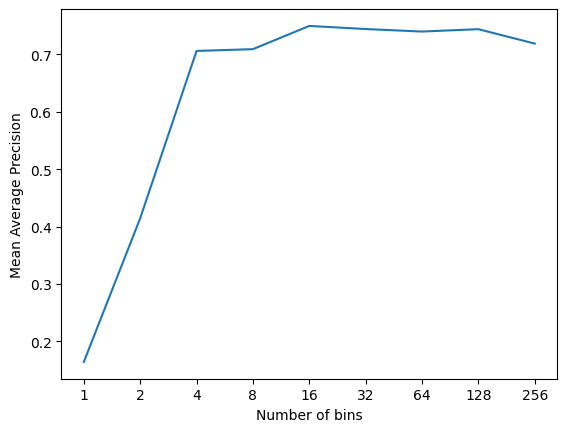

The optimal number of bins is 16, with a mAP of 0.7495141038871688


In [13]:
mAP_values = [0.0] * 9
for k in range(9):
    retriever = a1.GlobalCBIR(
        a1.compute_1d_color_hist,
        bins_per_hist = 2**k
    )
    
    mAP_values[k]=retriever.compute_mAP(dataset)
    
plt.plot(mAP_values)
plt.xlabel("Number of bins")
plt.ylabel("Mean Average Precision")
plt.xticks(list(range(9)), labels = [2**k for k in range(9)])
plt.show()

optimal_k = np.argmax(mAP_values)
print(f"The optimal number of bins is {2**optimal_k}, with a mAP of {mAP_values[optimal_k]}")

We can attempt to normalize the histograms differently, perhaps with the Manhattan norm instead of the euclidean:

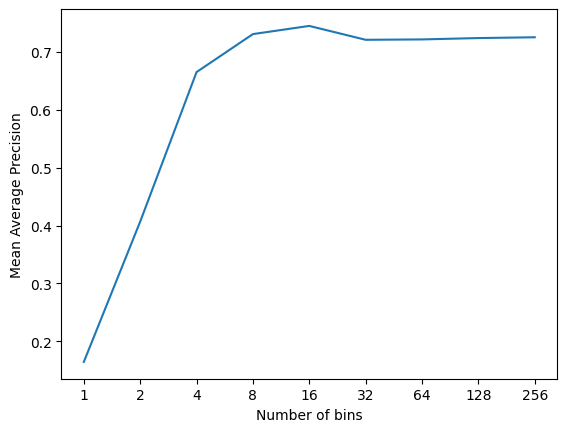

The optimal number of bins is 16, with a mAP of 0.7452589807852966


In [14]:
mAP_values = [0.0] * 9
for k in range(9):
    retriever = a1.GlobalCBIR(
        a1.compute_1d_color_hist,
        bins_per_hist = 2**k,
        norm_p = 1
    )
    
    mAP_values[k]=retriever.compute_mAP(dataset)
    
plt.plot(mAP_values)
plt.xlabel("Number of bins")
plt.ylabel("Mean Average Precision")
plt.xticks(list(range(9)), labels = [2**k for k in range(9)])
plt.show()

optimal_k = np.argmax(mAP_values)
print(f"The optimal number of bins is {2**optimal_k}, with a mAP of {mAP_values[optimal_k]}")

**Task 3:**

Again, using the `HolidaysDatasetHandler` and `CBIR` classes, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset. However, this time the image descriptors should be calculated using **2D histograms** with **8 bins**.

In [8]:
# Fill this variable with the resulting mAP
mAP_hist_2d = 0.0

# YOUR CODE HERE
cbir = a1.GlobalCBIR(a1.compute_2d_color_hist, bins_per_hist=8)
cbir.build_image_db(dataset.load_database_images())
mAP_hist_2d = cbir.compute_mAP(dataset)
# -----

print('Mean Average Precision (mAP): %.5f' % mAP_hist_2d)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.80455


**Task 4:**

As for the 1D case, study the effect of changing the number of bins per histogram.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

**Task 5:**

What other options can be implemented to improve the quality of retrieval using histograms? Experiment with some of them.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

### Local Binary Patterns (LBP)

Let's try LBP. Implement the function called `compute_lbp_descriptor` to calculate an image descriptor based on LBP. The descriptor should use the *rotation-invariant and uniform (RIU)* version of the algorithm. The final image descriptor will be the normalized histogram of the resulting LBP image.

> **Useful functions**: [skimage.feature.local_binary_pattern](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern)

Check your implementation using the following cell:

In [9]:
h = a1.compute_lbp_descriptor(image, 8, 1);
assert h.shape == (10, )

**Task 6:**

As previously, your task in the following cell is to compute the **mean Average Precision (mAP)** of this image retrieval system on this dataset using the `HolidaysDatasetHandler` and `CBIR` classes. However, this time, the descriptors should be calculated using the `compute_lbp_descriptor` function using **8 neighbors for each pixel at a distance of 1 pixel**.

In [10]:
# Fill this variable with the resulting mAP
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=8, r=1)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.62210


**Task 7:**

Study the effect of changing the number of neighboring pixels $p$ and the radius $r$.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

In [11]:
def show_histogram(image, p, r):
    fig, (ax_img, ax_hist) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    h = a1.compute_lbp_descriptor(image, p, r)

    ax_img.imshow(image, cmap='gray')
    ax_img.set_title(f'Image')
    ax_img.axis('off')

    ax_hist.bar(range(len(h)), h, color='gray', alpha=0.7)
    ax_hist.set_title('Histogram')
    ax_hist.set_xticks(np.arange(p + 2))

    plt.tight_layout()
    plt.show() 

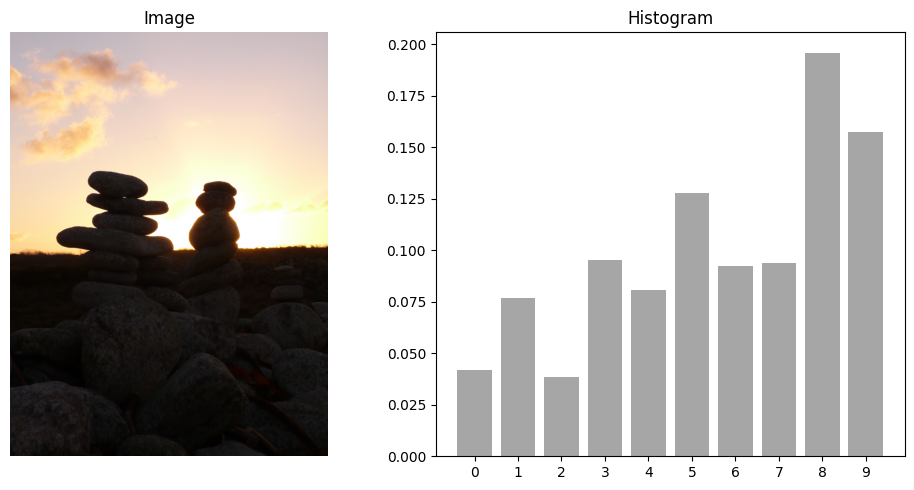

In [12]:
show_histogram(image, 8, 1)

In [13]:
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=4, r=1)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.62553


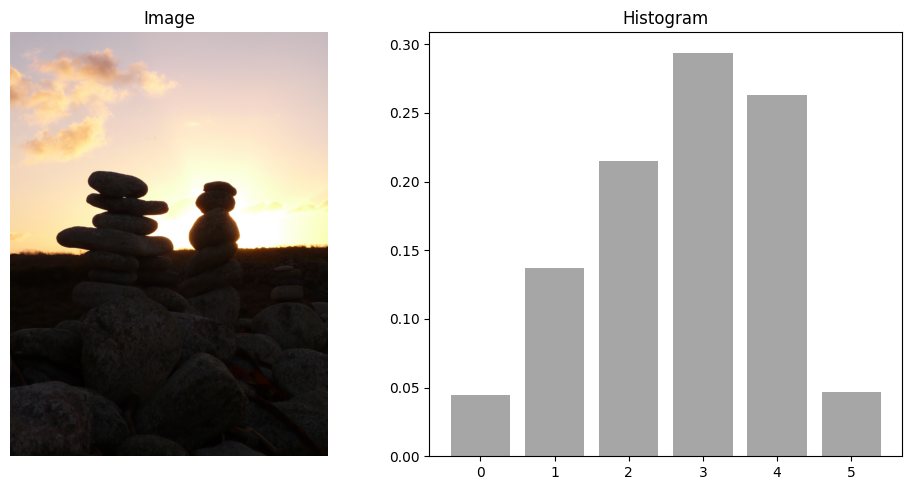

In [14]:
show_histogram(image, 4, 1)

In [15]:
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=12, r=2)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.58107


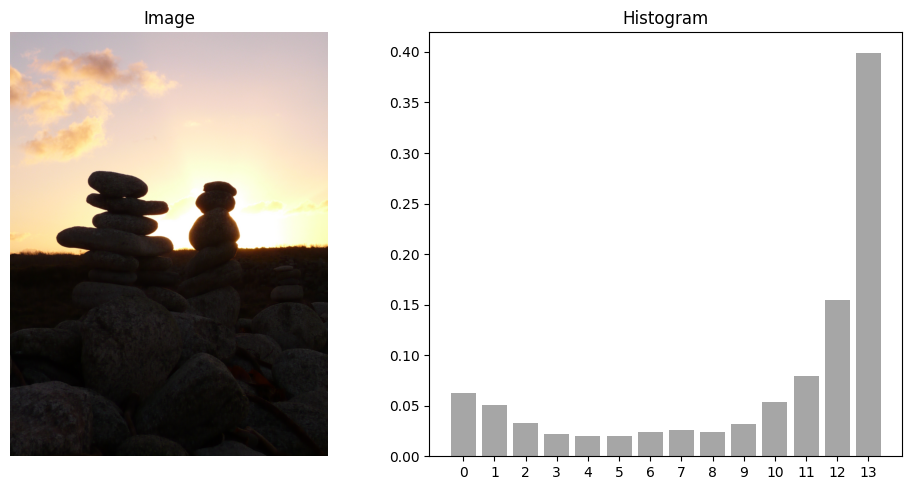

In [16]:
show_histogram(image, 12, 2)

In [17]:
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=16, r=2)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.58274


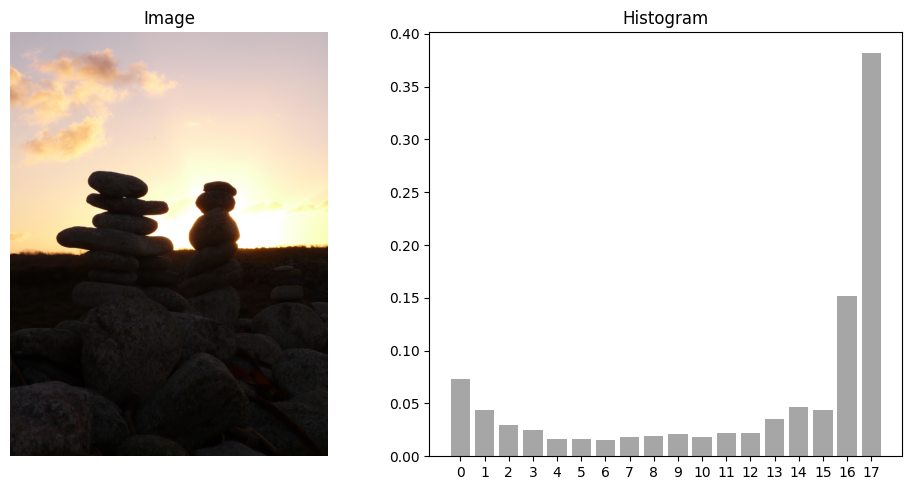

In [18]:
show_histogram(image, 16, 2)

In [19]:
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=24, r=3)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.54427


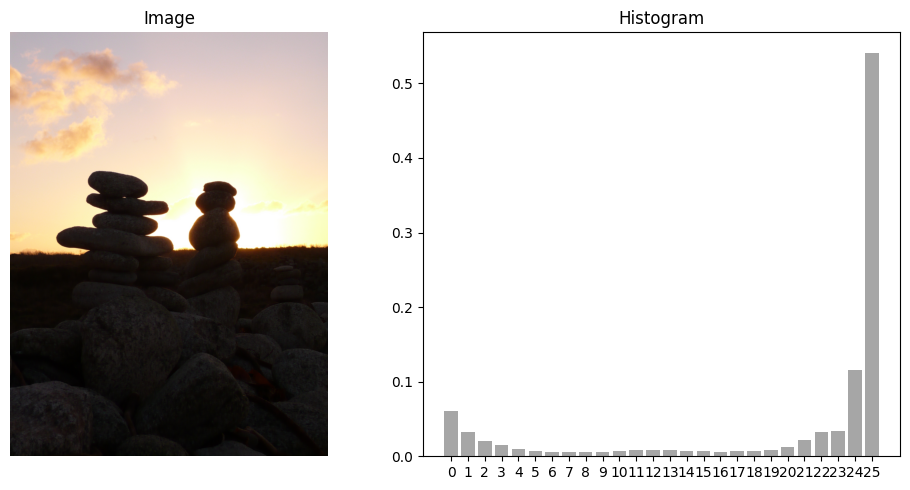

In [20]:
show_histogram(image, 24, 3)

In [21]:
mAP_lbp = 0.0

cbir = a1.GlobalCBIR(a1.compute_lbp_descriptor, p=8, r=3)
cbir.build_image_db(dataset.load_database_images())
mAP_lbp = cbir.compute_mAP(dataset)

print('Mean Average Precision (mAP): %.5f' % mAP_lbp)

######BUILDING IMAGE DATABASE######
######FINISHED RANKING IMAGES######
Mean Average Precision (mAP): 0.59619


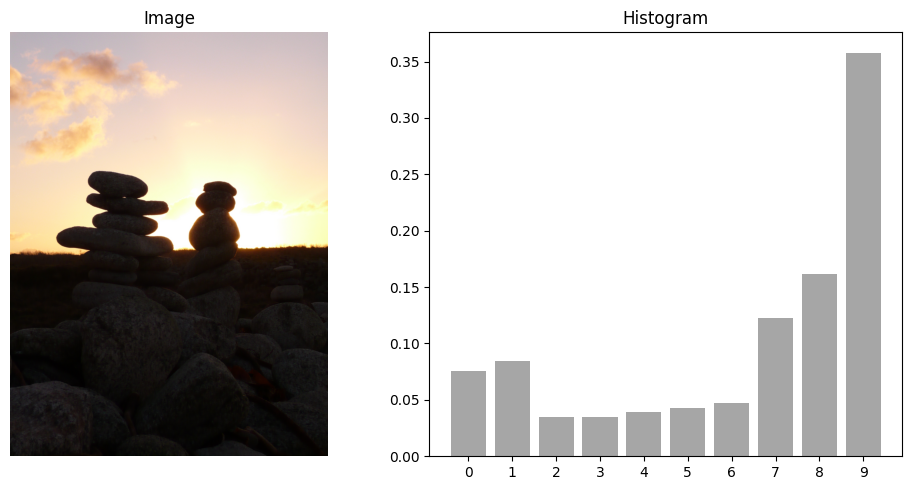

In [22]:
show_histogram(image, 8, 3)

**Task 8:**

Implement a grid over the image, computing the LBP histogram for each cell. Then, concatenate these histograms to form a global descriptor for the image. Investigate the impact of this improvement on the retrieval performance.

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

In [23]:

M = image.shape[0]//2
N = image.shape[1]//2
tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]


## **Local Descriptors**

In this section, we will focus on retrieving images by leveraging local descriptors discussed during the class. These descriptors will help us analyze and compare images based on their distinct visual features.

### Extracting Interest Points

Let's start by writing the function `extract_interest_points` in `assignment1.py` to extract a set of keypoints from an image along with their corresponding descriptors. The function will take a parameter called `feat_type` to specify the method used for keypoint detection and description. This parameter can have one of the following string values:

- **`SIFT`**: SIFT detector and descriptor.
- **`FAST_BRIEF`**: FAST detector with BRIEF descriptor.
- **`ORB`**: ORB detector and descriptor.


> **Useful functions**: [cv2.SIFT_create()](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131), [cv2.FastFeatureDetector_create](https://docs.opencv.org/4.5.4/df/d74/classcv_1_1FastFeatureDetector.html#ab986f2ff8f8778aab1707e2642bc7f8e), [cv2.xfeatures2d.BriefDescriptorExtractor_create](https://docs.opencv.org/4.5.4/d1/d93/classcv_1_1xfeatures2d_1_1BriefDescriptorExtractor.html#ae3bc52666010fb137ab6f0d32de51f60), [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

By combining these tools, you can implement the function to handle different types of keypoint detection and description techniques effectively.

Check your implementation using the following cell:

1590 keypoints detected.
Descriptors shape: (1590, 128)


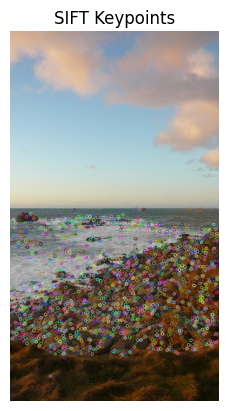

In [4]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False) # We don't need features now

# Get an image from the dataset
image_name = "100800.jpg"
image = dataset.get_image(image_name)

# Check if the image was loaded correctly
if image is None:
    print(f"Error: Could not load the image {image_name}.")
else:
    # Extract interest points and descriptors
    img_resized = cv2.resize(image, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    kps, des = a1.extract_interest_points(img_resized, 'SIFT', nfeats=2000, thresh=75)
    
    # Check if any keypoints were detected
    if len(kps) == 0:
        print("No keypoints were detected in the image.")
    else:
        print(f"{len(kps)} keypoints detected.")
        # Display the shape of the descriptors
        print(f"Descriptors shape: {des.shape}")
        
        # Draw the keypoints on the image
        sift_image = cv2.drawKeypoints(img_resized, kps, None)
        
        # Display the image without axes
        plt.imshow(sift_image)  # Convert BGR to RGB for Matplotlib
        plt.axis('off')  # Remove axes
        plt.title('SIFT Keypoints')
        plt.show()

### Matching Images

- Next, implement the function called `find_matches` to match two sets of descriptors. Since descriptor types vary, we will use:
    - **Brute-force matching** for binary descriptors (e.g., BRIEF, ORB).  
    - **FLANN-based matching** for floating-point descriptors (e.g., SIFT).
            
-  Implement the function called `filter_matches` to refine the matching results using the **Nearest Neighbor Distance Ratio (NNDR) criterion**. This method helps remove ambiguous matches by ensuring that the best match is significantly better than the second-best match. This helps to discard ambiguous matches and improves robustness by reducing false positives.

> **Useful links**: [cv2.BFMatcher_create](https://docs.opencv.org/4.5.4/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020), [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.4/dc/de2/classcv_1_1FlannBasedMatcher.html#a7b17083dda906384465a32952c1bbe3b), [Feature Matching](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html)

### Filtering Matches

Implement the function called `filter_matches` to refine the matching results using the **Nearest Neighbor Distance Ratio (NNDR) criterion**. This method helps remove ambiguous matches by ensuring that the best match is significantly better than the second-best match.

Check your implementation of these functions using the following cell:

Raw matches found: 1600
Filtered matches: 23


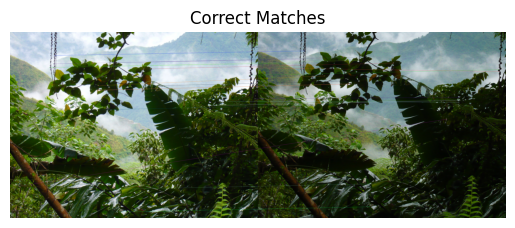

In [25]:
# Initialize the dataset handler
dataset = HolidaysDatasetHandler(dataset_dir, load_features=False)  # We don't need features now

# Get images from the dataset
image1_name = "100100.jpg"
image2_name = "100101.jpg"

image1 = dataset.get_image(image1_name)
image2 = dataset.get_image(image2_name)

# Check if images were loaded correctly
if image1 is None or image2 is None:
    print("Error: One or both images could not be loaded.")
else:
    # Extract keypoints and descriptors for both images
    kps_q, des_q = a1.extract_interest_points(image1, 'ORB', nfeats=1600, thresh=10)
    kps_t, des_t = a1.extract_interest_points(image2, 'ORB', nfeats=1600, thresh=10)

    # Check if descriptors were extracted properly
    if des_q is None or des_t is None or len(des_q) == 0 or len(des_t) == 0:
        print("Error: No descriptors found in one or both images.")
    else:
        # Find and filter matches
        raw_matches = a1.find_matches(des_q, des_t)
        print(f"Raw matches found: {len(raw_matches)}")

        matches = a1.filter_matches(raw_matches, ratio=0.6)
        print(f"Filtered matches: {len(matches)}")
        
        # Draw matches
        img_matches = cv2.drawMatches(
            image1, kps_q, image2, kps_t, matches, None, 
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )

        # Display the result
        plt.imshow(img_matches)
        plt.axis('off')  # Remove axes for a cleaner display
        plt.title('Correct Matches')
        plt.show()


## Evaluating Performance

Using the `HolidaysDatasetHandler` and the functions you have implemented, your task is to complete the `evaluate` function in `assignment1.py` to compute the **mean Average Precision (mAP)** for an image retrieval system based on **local image features**. This time, images will be compared using **local feature descriptors**. Given a query image, the closest match in the database will be the **image with the highest number of matches after filtering**. You should apply a **threshold** to determine the minimum number of matches required for an image to be considered a **correct match**.

**Task 9:**

In the following cell, your task is to compute the **mean Average Precision (mAP)** for the image retrieval system using the `evaluate()` function. The goal is to evaluate the retrieval system's performance for each method (SIFT, FAST/BRIEF, and ORB) and fine-tune their respective parameters to achieve the best possible mAP.

For each method:
1. **SIFT**: Adjust parameters such as the number of features (`nfeats`) and the threshold (`thresh`).
2. **FAST/BRIEF**: Experiment with the number of keypoints, thresholds, and descriptors.
3. **ORB**: Modify the number of features (`nfeats`) and other relevant settings.

Your objective is to achieve the highest mAP score by optimizing these parameters for each method.

In [6]:
# Fill these variables with the best resulting mAPs
best_mAP_SIFT = 0.0
best_mAP_FASTBRIEF = 0.0
best_mAP_ORB = 0.0

dataset = a1.DatasetHandler(dataset_dir, load_features=False)

sift_parameters = {'nfeats': [100, 500, 1000, 2000], 'thresh':[0], 'ratio':[0.6, 0.75]}
def sift_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'SIFT', nfeats, thresh, ratio)

sift_values_combinations = a1.evaluate_in_all_combinations(sift_callable, sift_parameters)

fastbrief_parameters = {'nfeats': [100, 500, 1000, 2000], 'thresh':[12, 25, 50, 100], 'ratio':[0.6, 0.75]}
def fastbrief_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'FAST_BRIEF', nfeats, thresh, ratio)

fastbrief_values_combinations = a1.evaluate_in_all_combinations(fastbrief_callable, fastbrief_parameters)

orb_parameters = {'nfeats': [1000, 2000, 4000, 8000], 'thresh':[12, 25, 50, 100], 'ratio':[0.6, 0.75]}
def orb_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'ORB', nfeats, thresh, ratio)


orb_values_combinations = a1.evaluate_in_all_combinations(orb_callable, orb_parameters)

best_mAP_SIFT = sift_values_combinations[0][1]
best_mAP_FASTBRIEF = fastbrief_values_combinations[0][1]
best_mAP_ORB = orb_values_combinations[0][1]

# Print the best mAPs for each method
print('Best mAP (SIFT): %.5f' % best_mAP_SIFT)
print('Best mAP (FAST/BRIEF): %.5f' % best_mAP_FASTBRIEF)
print('Best mAP (ORB): %.5f' % best_mAP_ORB)

Best mAP (SIFT): 0.80150
Best mAP (FAST/BRIEF): 0.75325
Best mAP (ORB): 0.72722


Besides knowing the best values, it is interesting to visualize which the best few combinations where. We'll focus on the first five. For SIFT:

In [7]:
print(sift_values_combinations[:5])

[({'nfeats': 1000, 'thresh': 25, 'ratio': 0.6}, 0.8015005462373883), ({'nfeats': 1000, 'thresh': 50, 'ratio': 0.6}, 0.800501253132832), ({'nfeats': 500, 'thresh': 25, 'ratio': 0.6}, 0.7636591478696741), ({'nfeats': 500, 'thresh': 50, 'ratio': 0.6}, 0.7371498599439775), ({'nfeats': 1000, 'thresh': 50, 'ratio': 0.75}, 0.7010844418739155)]


For FAST+BRIEF:

In [8]:
print(fastbrief_values_combinations[:5])

[({'nfeats': 100, 'thresh': 25, 'ratio': 0.75}, 0.7532496012759171), ({'nfeats': 500, 'thresh': 25, 'ratio': 0.75}, 0.7532496012759171), ({'nfeats': 1000, 'thresh': 25, 'ratio': 0.75}, 0.7532496012759171), ({'nfeats': 100, 'thresh': 25, 'ratio': 0.6}, 0.7513017168589924), ({'nfeats': 500, 'thresh': 25, 'ratio': 0.6}, 0.7513017168589924)]


And, finally, for ORB:

In [9]:
print(orb_values_combinations[:5])

[({'nfeats': 2000, 'thresh': 25, 'ratio': 0.75}, 0.727218782249742), ({'nfeats': 2000, 'thresh': 50, 'ratio': 0.75}, 0.7055555555555555), ({'nfeats': 1000, 'thresh': 25, 'ratio': 0.75}, 0.6492468058257532), ({'nfeats': 2000, 'thresh': 50, 'ratio': 0.6}, 0.6021992481203008), ({'nfeats': 2000, 'thresh': 25, 'ratio': 0.6}, 0.5939853892724272)]


In the previous task, we attempted to find the best parameter combination for each of the methods, separately. For a fair comparison, we will now fix all parameters and compare the methods in terms of their mAP. Looking at the results of the
previous task, 1000 features seems like a good number, smaller ratios tend to work best and so does the threshold of 25.

In [16]:
parameters = {'nfeats':1000, 'thresh':25, 'ratio':0.6}

methods = ["SIFT", "FAST_BRIEF", "ORB"]

performances = {method: a1.evaluate(dataset, method, **parameters) for method in methods}

for method, mAP in performances.items():
    print(f"Mean Average Precision for {method}:\t{mAP}")

Mean Average Precision for SIFT:	0.7952766531713901
Mean Average Precision for FAST_BRIEF:	0.7513017168589924
Mean Average Precision for ORB:	0.552143516686453


It will be interesting to compare the methods more thoroughly, but this will be done later, taking into account the execution times and a more detailed discussion of parameters.

**Task 11:**

Compare the three methods in terms of detection and description speed. Which one is the fastest? Which one is the slowest?

> **Hints**:
> - [Here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) you can find a useful resource on timing in Jupyter Notebooks.
> - You can also consider using the `time` module.
> - To provide a measure independent of the number of features detected, you can compute, for example, features per millisecond (features/ms).

*Write in the following the code required to answer the question. You may add more code or markdown cells as needed.*

For this task, we will repeat the experiment of task 9, but this time adding a time benchmark. For this, we can write a simple and generic utility function for measuring the time a function takes to execute.
See `benchmark_ms` in `assignment1.py` for the implementation details.

Now, we incorporate this into the previous workflow by writing a modification of the `evaluate_in_all_combinations` method. See `evaluate_and_benchmark_in_all_combinations`.

In [ ]:
parameter_lists = {'nfeats': [100, 500, 1000], 'thresh':[25, 50], 'ratio':[0.6, 0.75]}
methods = ["SIFT", "FAST_BRIEF", "ORB"]

dataset = a1.DatasetHandler(dataset_dir, load_features=False)

def sift_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'SIFT', nfeats, thresh, ratio)

def fastbrief_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'FAST_BRIEF', nfeats, thresh, ratio)

def orb_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'ORB', nfeats, thresh, ratio)

callables={
    "SIFT":sift_callable,
    "FAST_BRIEF":fastbrief_callable,
    "ORB":orb_callable
}

results = {}

for method in methods:
    results[method] = a1.evaluate_and_benchmark_in_all_combinations(callables[method], parameter_lists)

In [ ]:
expanded_results = []
for method, result in results.items():

    method_results = list(map(lambda d: {'method':method, **d}, result))
    expanded_results.extend(method_results)

In [ ]:
with open('timed_results.json', 'w', encoding='utf-8') as f:
    json.dump(expanded_results, f, indent=4)

print(f"Successfully wrote data")

In [5]:
with open('timed_results.json', 'r', encoding='utf-8') as f:
    timed_results = json.load(f)

In [7]:
for result in timed_results:
    result["feats/ms"]=result["nfeats"]/result["execution_time_ms"]

mAP_groups=[(0.0, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 1.0)]

for result in timed_results:
    group_idx = 0
    for group in range(len(mAP_groups)):
        if mAP_groups[group][0] <= result["mAP"] < mAP_groups[group][1]:
            group_idx = group

    result["mAP_group"] = group_idx

print(sorted(
    filter(lambda res: res["mAP_group"] == 2, timed_results),
    key=lambda res: res["feats/ms"], reverse=True))


[{'mAP': 0.6492468058257532, 'method': 'ORB', 'execution_time_ms': 4509.848117828369, 'nfeats': 1000, 'thresh': 25, 'ratio': 0.75, 'feats/ms': 0.22173695740368543, 'mAP_group': 2}, {'mAP': 0.6946755475645636, 'method': 'SIFT', 'execution_time_ms': 40387.115478515625, 'nfeats': 1000, 'thresh': 50, 'ratio': 0.75, 'feats/ms': 0.024760371919404868, 'mAP_group': 2}, {'mAP': 0.6581167831860353, 'method': 'SIFT', 'execution_time_ms': 34047.14560508728, 'nfeats': 500, 'thresh': 25, 'ratio': 0.75, 'feats/ms': 0.014685518891935853, 'mAP_group': 2}, {'mAP': 0.6677128427128427, 'method': 'SIFT', 'execution_time_ms': 36074.92709159851, 'nfeats': 500, 'thresh': 50, 'ratio': 0.75, 'feats/ms': 0.01386004187147602, 'mAP_group': 2}, {'mAP': 0.6479837121942386, 'method': 'SIFT', 'execution_time_ms': 35466.2549495697, 'nfeats': 100, 'thresh': 50, 'ratio': 0.6, 'feats/ms': 0.0028195816034761027, 'mAP_group': 2}, {'mAP': 0.6481672006048737, 'method': 'SIFT', 'execution_time_ms': 40066.43891334534, 'nfeats':

In [11]:
parameter_lists = {'nfeats': [4000, 6000, 8000], 'thresh':[25], 'ratio':[0.75]}
dataset = a1.DatasetHandler(dataset_dir, load_features=False)
def orb_callable(nfeats, thresh, ratio):
    return a1.evaluate(dataset, 'ORB', nfeats, thresh, ratio)
a1.evaluate_and_benchmark_in_all_combinations(orb_callable, parameter_lists)

[({'nfeats': 8000, 'thresh': 25, 'ratio': 0.75},
  0.8500604960677557,
  52795.544147491455),
 ({'nfeats': 6000, 'thresh': 25, 'ratio': 0.75},
  0.7821428571428571,
  29190.022230148315),
 ({'nfeats': 4000, 'thresh': 25, 'ratio': 0.75},
  0.7368254011361393,
  16943.331718444824)]

## Submitting Your Work

**Important**: Please ensure that the notebook has been run and that the **cell outputs are visible**.

**Important**: Additionally, make sure you have filled in the names at the beginning of the notebook and the **ID** variable in the following cell.

Once you have completed the necessary code and are satisfied with your solution, **save your notebook** and run the following cell:

In [ ]:
ID = '99999999R' # Your DNI or NIE

zip_filename = ID + '_A1.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

zf.write('11762_Image_Description.ipynb');
zf.write('assignment1.py');
zf.write('holidays_dataset_handler.py');

zf.close()

This will generate a zip file of your code called `ID_A1.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://ad.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands